In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re # For basic text cleaning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Import TensorFlow and Keras components
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# --- Configuration ---
file_path = r'D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\cleaned_taptap_reviews.csv'
text_column = 'review_content' # Column with text reviews
target_column = 'sentiment'    # Column with sentiment labels
test_size = 0.2
random_state = 42

# --- BiLSTM Model Hyperparameters ---
VOCAB_SIZE = 20000   # Max number of words to keep in the vocabulary
MAX_LEN = 200        # Max length of sequences (pad/truncate reviews to this length)
EMBEDDING_DIM = 256  # Dimension of word embeddings
LSTM_UNITS = 128     # Number of units in the LSTM layer
DROPOUT_RATE = 0.7   # Dropout rate for regularization
EPOCHS = 20          # Max number of training epochs
BATCH_SIZE = 512     # Batch size for training

In [3]:
# --- 1. Load Data ---
print(f"开始加载数据: {file_path}")
try:
    df = pd.read_csv(file_path)
    print(f"数据加载成功，总行数: {len(df)}")
    # Select only necessary columns
    df = df[[text_column, target_column]].copy()

    # Basic Missing Value Handling
    df[text_column] = df[text_column].fillna('') # Fill missing reviews
    df.dropna(subset=[target_column], inplace=True) # Drop rows where target is missing
    print(f"\n处理必要列的缺失值后，剩余行数: {len(df)}")

    # Ensure target column is integer type
    df[target_column] = df[target_column].astype(int)

    print("\n数据信息 (选择的列):")
    df.info()
    print(f"\n目标变量 '{target_column}' 分布:")
    print(df[target_column].value_counts(normalize=True))

except FileNotFoundError:
    print(f"错误: 文件未找到 {file_path}")
    exit()
except Exception as e:
    print(f"加载或初步处理数据时发生错误: {e}")
    exit()

# --- Optional: Basic Text Cleaning (Example) ---
def clean_text(text):
    text = str(text).lower() # Lowercase
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'[^a-z0-9\s\u4e00-\u9fff]', '', text) # Keep alphanumeric, spaces, and Chinese characters
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

# print("\n开始文本清洗...")
# df[text_column] = df[text_column].apply(clean_text)
# print("文本清洗完成。")
# Note: Cleaning might remove important punctuation or emojis depending on the regex.
# Consider using a dedicated Chinese tokenizer like jieba if needed for better word segmentation.

开始加载数据: D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\cleaned_taptap_reviews.csv
数据加载成功，总行数: 39985

处理必要列的缺失值后，剩余行数: 39985

数据信息 (选择的列):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39985 entries, 0 to 39984
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review_content  39985 non-null  object
 1   sentiment       39985 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 468.7+ KB

目标变量 'sentiment' 分布:
sentiment
1    0.659072
0    0.340928
Name: proportion, dtype: float64


In [4]:
# --- 2. Prepare Features and Target ---
X = df[text_column].values
y = df[target_column].values

In [5]:
# --- 3. Split Data ---
print(f"\n划分数据集，测试集比例: {test_size}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)
print(f"训练集大小: {X_train.shape[0]}, 测试集大小: {X_test.shape[0]}")


划分数据集，测试集比例: 0.2
训练集大小: 31988, 测试集大小: 7997


In [6]:
# --- 4. Text Preprocessing (Tokenization & Padding) ---
print("\n开始文本预处理 (Tokenization 和 Padding)...")
# Initialize Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>") # <OOV> handles words not in vocabulary

# Fit Tokenizer ONLY on training data
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 # +1 for padding token 0
print(f"词汇表大小 (实际): {vocab_size}") # Can be smaller than VOCAB_SIZE

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"处理后训练数据维度: {X_train_pad.shape}")
print(f"处理后测试数据维度: {X_test_pad.shape}")
print("文本预处理完成。")


开始文本预处理 (Tokenization 和 Padding)...
词汇表大小 (实际): 61764
处理后训练数据维度: (31988, 200)
处理后测试数据维度: (7997, 200)
文本预处理完成。


In [7]:
# --- 5. Build BiLSTM Model ---
print("\n构建 BiLSTM 模型...")
model = Sequential([
    # 1. Embedding Layer
    Embedding(input_dim=vocab_size, # Use actual vocab size
              output_dim=EMBEDDING_DIM,
              input_length=MAX_LEN),
    # Optional: Dropout after embedding helps prevent overfitting
    SpatialDropout1D(0.2),

    # 2. Bidirectional LSTM Layer
    Bidirectional(LSTM(units=LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2)),
    # Note: recurrent_dropout can sometimes slow down training on GPU.
    # Consider removing it if training is too slow.

    # Optional: Dropout before the final layer
    Dropout(DROPOUT_RATE),

    # 3. Output Layer
    # Binary classification: 1 unit with sigmoid activation
    Dense(units=1, activation='sigmoid')
])


构建 BiLSTM 模型...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
# --- 6. Compile Model ---
print("编译模型...")
model.compile(
    loss='binary_crossentropy', # Loss function for binary classification
    optimizer='adam',           # Adam optimizer is generally a good default
    metrics=['accuracy']        # Monitor accuracy during training
)

model.summary() # Print model architecture

编译模型...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- 7. Train Model ---
print("\n开始训练模型 (TensorFlow/Keras 会自动使用 GPU 如果可用)...")
# Define callbacks (e.g., EarlyStopping)
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor loss on the validation set
    patience=3,         # Stop after 3 epochs with no improvement
    restore_best_weights=True # Restore model weights from the epoch with the best val_loss
)

start_time = time.time()
history = model.fit(
    X_train_pad, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_pad, y_test), # Use test set for validation during training
    callbacks=[early_stopping],
    verbose=1 # Show progress bar per epoch
)
end_time = time.time()
print(f"模型训练完成，耗时: {end_time - start_time:.2f} 秒")


开始训练模型 (TensorFlow/Keras 会自动使用 GPU 如果可用)...
Epoch 1/20
15/63 ━━━━━━━━━━━━━━━━━━━━ 24s 503ms/step - accuracy: 0.6167 - loss: 0.6599

In [ ]:
# --- 8. Evaluate Model ---
print("\n在测试集上评估模型...")
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"测试集损失 (Loss): {loss:.4f}")
print(f"测试集准确率 (Accuracy): {accuracy:.4f}")


在测试集上评估模型...
测试集损失 (Loss): 0.4256
测试集准确率 (Accuracy): 0.8003



生成预测和评估报告...
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.71      2726
           1       0.85      0.85      0.85      5271

    accuracy                           0.80      7997
   macro avg       0.78      0.78      0.78      7997
weighted avg       0.80      0.80      0.80      7997


Confusion Matrix:
[[1916  810]
 [ 787 4484]]


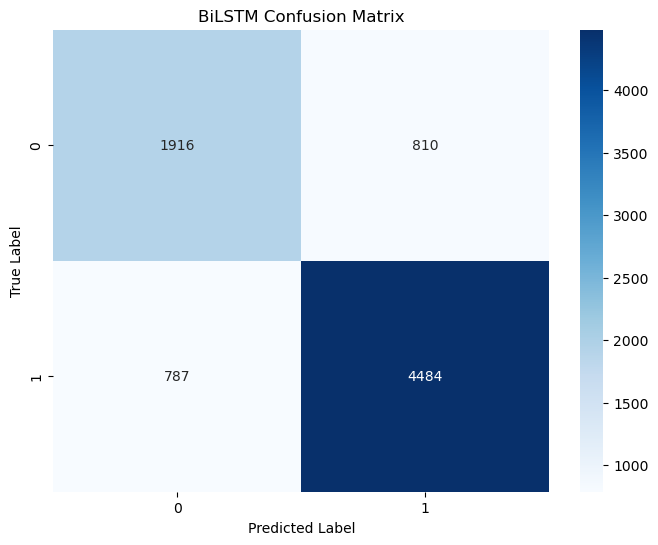

In [ ]:
# --- 9. Make Predictions & Generate Reports ---
print("\n生成预测和评估报告...")
# Predict probabilities
y_pred_prob = model.predict(X_test_pad)
# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten() # Flatten needed as output might be (n_samples, 1)

# Classification Report
print("Classification Report:")
try:
    target_names = [str(c) for c in sorted(np.unique(y_test))] # Get unique class labels
    print(classification_report(y_test, y_pred, target_names=target_names))
except Exception as e:
    print(f"生成 classification report 时出错: {e}")
    print("Classification Report (无 target_names):")
    print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('BiLSTM Confusion Matrix')
plt.show()


绘制训练历史...


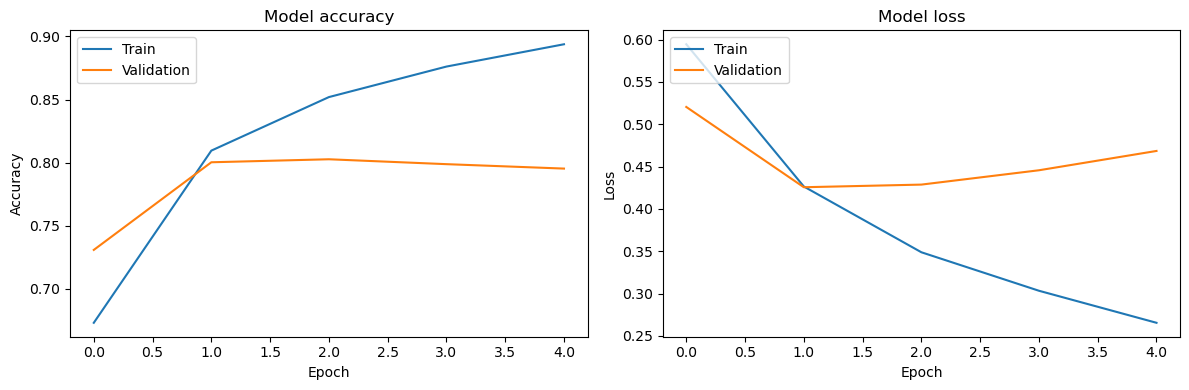


脚本执行完毕。


In [ ]:
# --- Optional: Plot Training History ---
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

print("\n绘制训练历史...")
plot_history(history)

print("\n脚本执行完毕。")